# Knowledge Improvement and Post-test Activity

We study here the relation that may exist between knowledge improvement and users' activities on didactalia and on the AFEL App after the knowledge post-test.

# Imports & Constants

## Fuseki Endpoint : you might want to change it!

In [1]:
FUSEKI_DATASET = "evalafel" # Change according your own dataset name
SPARQL_ENDPOINT = "http://localhost:3030/%s/query" % FUSEKI_DATASET

## Imports, constant settings

In [2]:
from SPARQLWrapper import SPARQLWrapper, CSV
from rdflib import Literal
import numpy as np
import pandas as pd
from io import BytesIO
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Normalizer
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

In [3]:
SPARQL_PREFIX = """
    PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX afl: <http://vocab.afel-project.eu/>
    PREFIX extafl: <http://vocab.afel-project.eu/extension/>
    PREFIX sch: <http://schema.org/>
    
"""

In [4]:
# Setting seaborn to have proper visualisation adapted to jupyter notebook
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [5]:
def sparql_to_dataframe(query, **kwargs):
    sparql = SPARQLWrapper(SPARQL_ENDPOINT)
    sparql.setQuery(query)
    sparql.setReturnFormat(CSV)
    res = sparql.query().convert()
    try:
        with BytesIO(res) as sio:
            return pd.read_csv(sio, **kwargs)
    finally:
        del res
        gc.collect()

# Knowledge Increasment Extraction

In [6]:
def get_knowledge_cognitive_tests():
    """
    Retrieve the results of the cognitives pre and post tests in geography and history
    """
    query = SPARQL_PREFIX + """
    SELECT ?userid ?questionID ?ratingValue
    WHERE { 
      $action a sch:ChooseAction .
      $action sch:endTime ?time .
      $action sch:actionOption $rating .
      $rating sch:ratingValue ?ratingValue .
      $action sch:object $question .
      $question sch:identifier ?questionID .
      $question sch:isPartOf $questionnaire .
      $rating sch:author $user .
      $user afl:userName ?userid .
      FILTER regex(?questionID, "^AFEL_2_KNOW") .
    }
    """
    return sparql_to_dataframe(query)

In [7]:
def process_know_stats(df_know_tests):
    '''
    from the results of test, compute two dataframes that provide min, mean& max score
    of knowledge increasing for each user for both geopgraphy and history tests.
    '''
    def process_sub_test_df(sub_df):
        # Compute relative id of questions
        sub_df['questionID'] = sub_df.questionID.str.extract('AFEL_2_KNOW_(?:PRE|POST)_(?:GEO|HIST)_(.*)', expand=False)
        # Compute pivot table to have questionID as columns
        return sub_df.pivot(index='userid', columns='questionID', values='ratingValue')
    # convert userid into simpler int userid
    df_know_tests['userid'] = np.vectorize(int)(df_know_tests.userid.str.extract('project.afel\+(\d+)', expand=False))
    # split test results into four independent dataframes
    df_pre_geo = process_sub_test_df(df_know_tests.loc[df_know_tests.questionID.str.startswith('AFEL_2_KNOW_PRE_GEO'),:].copy())
    df_pre_hist = process_sub_test_df(df_know_tests.loc[df_know_tests.questionID.str.startswith('AFEL_2_KNOW_PRE_HIST'),:].copy())
    df_post_geo = process_sub_test_df(df_know_tests.loc[df_know_tests.questionID.str.startswith('AFEL_2_KNOW_POST_GEO'),:].copy())
    df_post_hist = process_sub_test_df(df_know_tests.loc[df_know_tests.questionID.str.startswith('AFEL_2_KNOW_POST_HIST'),:].copy())
    # Compute differences of scores
    df_diff_geo = df_post_geo - df_pre_geo
    df_diff_hist = df_post_hist - df_pre_hist
    # Remove partial results
    df_diff_geo.dropna(inplace=True)
    df_diff_hist.dropna(inplace=True)
    # Compute min, max and mean score for each user
    df_know_geo_stats = df_diff_geo.apply(axis=1, func=lambda x: {'minKnow':x.min(), 'meanKnow':x.mean(), 'maxKnow':x.max(), 'stdKnow': x.std()}, 
                                  result_type='expand')
    df_know_hist_stats = df_diff_hist.apply(axis=1, func=lambda x: {'minKnow':x.min(), 'meanKnow':x.mean(), 'maxKnow':x.max(), 'stdKnow': x.std()}, 
                                  result_type='expand')
    # Assert that a user has not participated to both tests
    assert len(set(df_know_geo_stats.index.values) & set(df_know_hist_stats.index.values)) == 0
    return pd.concat([df_know_geo_stats, df_know_hist_stats])

In [8]:
df_know_stats = process_know_stats(get_knowledge_cognitive_tests())

# Activities Extraction

In [9]:
def get_user_didactalia_activities():
    query = SPARQL_PREFIX + """
    SELECT ?userid ?location ?activityType ?artId ?actStartTime ?actEndTime
    WHERE {
        $activity a ?activityType .
        $activity afl:user ?user .
        $activity afl:artifact $artifact .
        
        $activity afl:eventStartDate ?actStartTime .
        $activity afl:eventEndDate ?actEndTime .
        $activity sch:location ?location .
        ?user afl:userName ?userid .
        $artifact afl:resourceID ?artId .
        
        FILTER(?activityType IN (afl:ArtifactView, extafl:DidactaliaGamePlayed, extafl:RecommendedArtifactView, extafl:ScopeView)) .
        FILTER(?actStartTime >= ?timePost) .
        {
            SELECT ?user (MAX(?timeTest) AS ?timePost)
            WHERE {
                $action a sch:ChooseAction .
                $action sch:object $question .
                $question a sch:Question.
                $question sch:isPartOf $questionnaire .
                $questionnaire a extafl:Questionnaire .
                $action sch:agent $user .
                $user a afl:User .
                $action sch:endTime ?timeTest .
                $questionnaire sch:identifier ?questionnaireId .
                FILTER(REGEX(?questionnaireId, "AFEL_2_KNOW_(PRE|POST)_(HIST|GEO)")) .
            }
            GROUP BY ?user ?catQuest
        }
    }
    """
    return sparql_to_dataframe(query, parse_dates=[3, 4])

In [10]:
df_activities = get_user_didactalia_activities()

### Convert usernames to ids

In [11]:
df_activities['userid'] = np.vectorize(int)(df_activities.userid.str.extract('project.afel\+(\d+)', expand=False))

# Analyze number of activities and knowledge improvement

In [12]:
df_num_activities = df_activities.reset_index().loc[:, ['userid', 'index']]\
.groupby('userid').count()\
.rename(columns={'index':'numActivities'})

In [13]:
df_num_activities = pd.merge(df_num_activities, df_know_stats, 
                            on='userid', validate='one_to_one')

### Distribution analysis

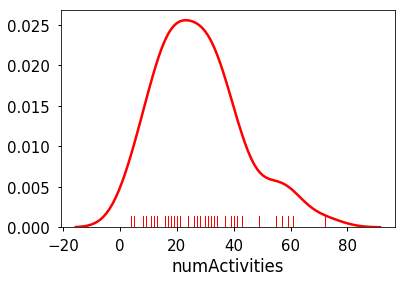

In [14]:
sns.distplot(df_num_activities.numActivities, hist=False, rug=True, color="r")

### Correlation analysis

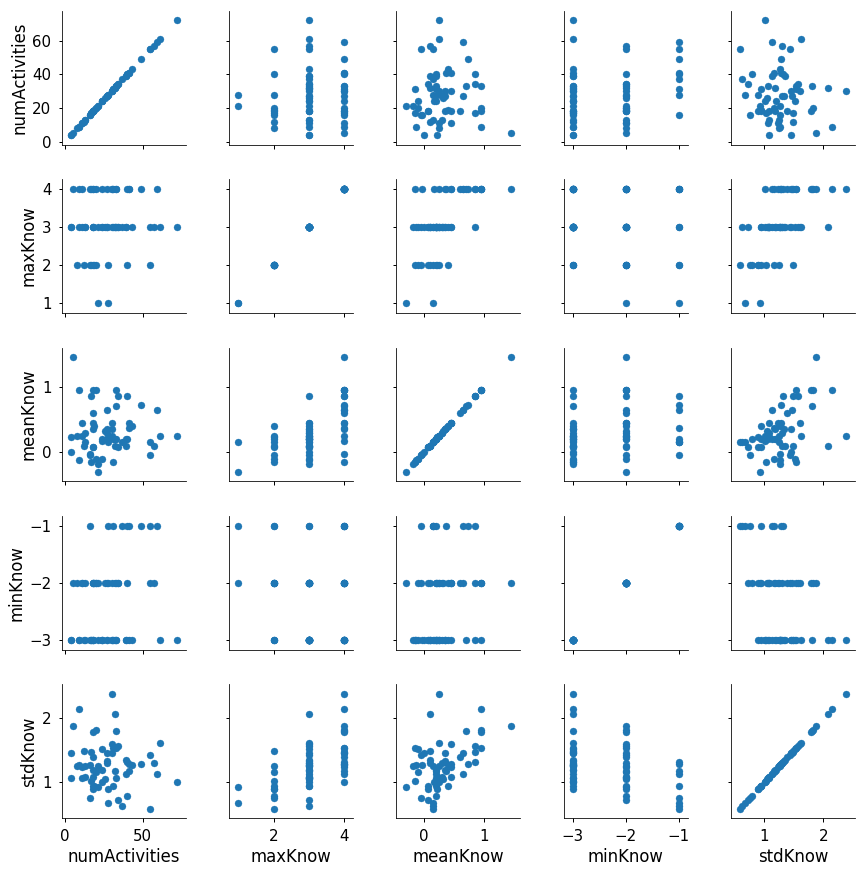

In [15]:
g = sns.PairGrid(df_num_activities)
g = g.map(plt.scatter)

In [16]:
for depVar in ['minKnow', 'meanKnow', 'maxKnow', 'stdKnow']:
    r, pval = pearsonr(df_num_activities[depVar], df_num_activities.numActivities)
    indicator = '***' if pval < .05 else ''
    print("%s: r = %.3f pval = %.3f %s" % (depVar, r, pval, indicator))

minKnow: r = 0.231 pval = 0.071 
meanKnow: r = -0.013 pval = 0.917 
maxKnow: r = 0.076 pval = 0.556 
stdKnow: r = -0.111 pval = 0.388 


# Analysis of number of activity of a certain type/location and knowledge improvement

In [17]:
df_activities['actFullType'] = \
np.vectorize(lambda x: 'DIDA_' if x == 'https://didactalia.net' else 'AFEL_')(df_activities.location)\
+ df_activities.activityType.str.split('/').str.get(-1)

In [18]:
df_details_activities = df_activities.reset_index().loc[:, ['userid', 'actFullType', 'index']]\
.groupby(['userid', 'actFullType']).count()\
.rename(columns={'index':'numActivities'})\
.reset_index()\
.pivot(index='userid', columns='actFullType', values='numActivities')\
.fillna(0)

In [19]:
df_details_activities = pd.merge(df_details_activities, df_know_stats, on='userid', validate='one_to_one')

### Correlation analysis

In [20]:
def correl_test(df, features):
    for feature in features:
        print("Correlation btwn %s and know" % feature)
        for indic_know in ['meanKnow', 'minKnow', 'maxKnow', 'stdKnow']:
            print(" - %s:" % indic_know)
            res = pearsonr(df[indic_know], df[feature])
            suff = '***' if res[1] < .05 else ''
            print("      r = %.3f p-value = %.5f %s" % (res[0], res[1], suff))

In [21]:
df_details_activities.columns

Index(['AFEL_ArtifactView', 'AFEL_RecommendedArtifactView', 'AFEL_ScopeView',
       'DIDA_ArtifactView', 'DIDA_DidactaliaGamePlayed', 'maxKnow', 'meanKnow',
       'minKnow', 'stdKnow'],
      dtype='object')

In [22]:
correl_test(df_details_activities, ['AFEL_ArtifactView', 'AFEL_RecommendedArtifactView', 'AFEL_ScopeView',
       'DIDA_ArtifactView', 'DIDA_DidactaliaGamePlayed'])

Correlation btwn AFEL_ArtifactView and know
 - meanKnow:
      r = -0.044 p-value = 0.73608 
 - minKnow:
      r = 0.094 p-value = 0.46715 
 - maxKnow:
      r = -0.286 p-value = 0.02401 ***
 - stdKnow:
      r = 0.051 p-value = 0.69366 
Correlation btwn AFEL_RecommendedArtifactView and know
 - meanKnow:
      r = 0.026 p-value = 0.84317 
 - minKnow:
      r = -0.112 p-value = 0.38684 
 - maxKnow:
      r = 0.019 p-value = 0.88108 
 - stdKnow:
      r = 0.365 p-value = 0.00350 ***
Correlation btwn AFEL_ScopeView and know
 - meanKnow:
      r = 0.097 p-value = 0.45441 
 - minKnow:
      r = -0.170 p-value = 0.18576 
 - maxKnow:
      r = 0.218 p-value = 0.08812 
 - stdKnow:
      r = 0.085 p-value = 0.50887 
Correlation btwn DIDA_ArtifactView and know
 - meanKnow:
      r = 0.050 p-value = 0.70035 
 - minKnow:
      r = 0.294 p-value = 0.02045 ***
 - maxKnow:
      r = -0.031 p-value = 0.80984 
 - stdKnow:
      r = -0.053 p-value = 0.68510 
Correlation btwn DIDA_DidactaliaGamePlayed an